In [376]:
import pandas as pd
from scipy import stats
import numpy as np
import statsmodels.api as sm
import warnings
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 10, 8

---

## Load & show series

            WAG_C_M
month              
1993-01-01     15.3
1993-02-01     19.1
1993-03-01     23.6
1993-04-01     30.6
1993-05-01     37.5


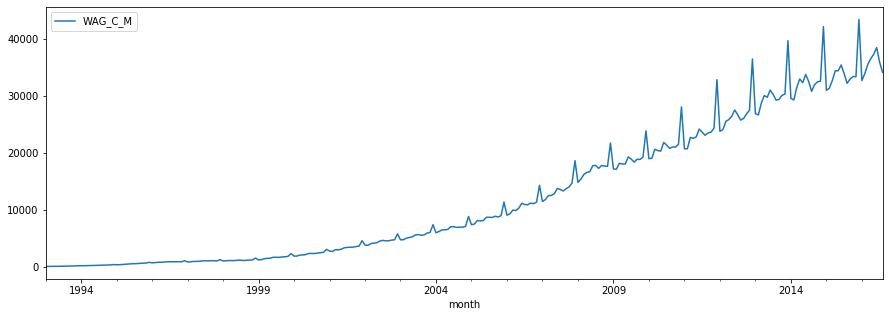

In [99]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col=0)
data.index = pd.to_datetime(data.index, format='%d.%m.%Y')

print(data.head())
data.plot(figsize=[15, 5])
plt.show()


---

## Time series stationarity & common observation

From the plot we can see the series is not stationary. <br>
But formally check the stationarity of the series by Dickey-Fuller test.

In [243]:
# stationarity (dickey fuller test)
def stationarity(series):
    return sm.tsa.stattools.adfuller(series)
# STL-decomposition (Seasonal and Trend decomposition using Loess)
def STLdecomp(series, freq=None):
    return sm.tsa.seasonal_decompose(series, freq=freq)

Dickey-Fuller test: pvalue =  0.9918495954854735


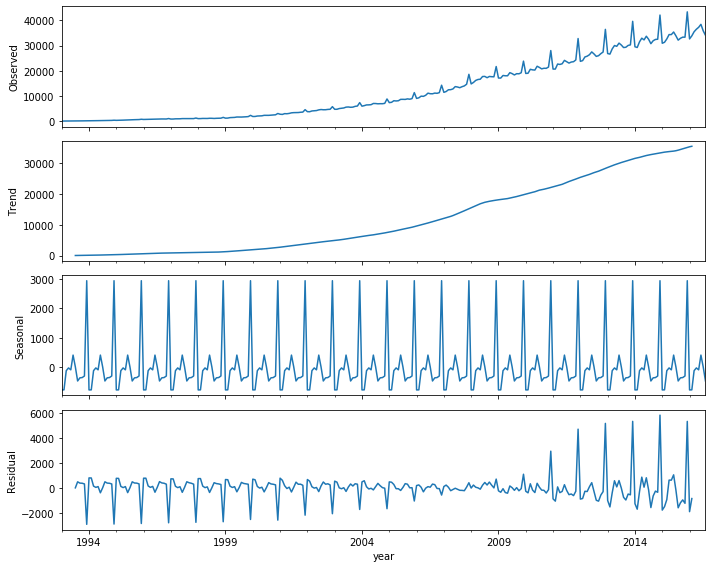

In [517]:
print('Dickey-Fuller test: pvalue = ', stationarity(data['WAG_C_M'])[1])

STL = STLdecomp(data['WAG_C_M'])
STL.plot()
plt.xlabel('year')
plt.show()

Some trend, seasonality, and unstable dispersion

---

## Series transform

In [170]:
# Box Cox transformation
def boxcox_transfrom(series):
    return stats.boxcox(series)

# differentiation
def differentiation(series, period=1):
    return series - series.shift(period)

### 1. BoxCox transform (dispersion stabilization)

Optimal BoxCox parameter:  0.2632017541844584
Dickey-Fuller test: pvalue =  0.6968987634832662


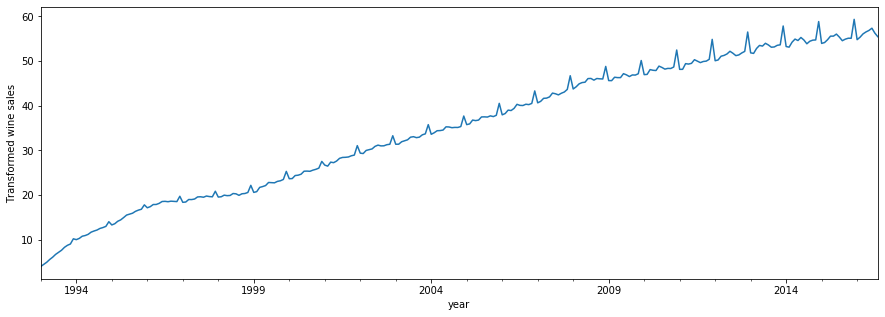

In [518]:
data['WAG_C_M_boxcox'], lmbda = boxcox_transfrom(data['WAG_C_M'])

print('Optimal BoxCox parameter: ', lmbda)
print('Dickey-Fuller test: pvalue = ', stationarity(data['WAG_C_M_boxcox'])[1])

plt.figure(figsize=[15, 5])
data['WAG_C_M_boxcox'].plot()
plt.ylabel(u'Transformed wine sales')
plt.xlabel('year')
plt.show()

### 2. Differetiation 

Dickey-Fuller test: pvalue =  0.01439615216494525


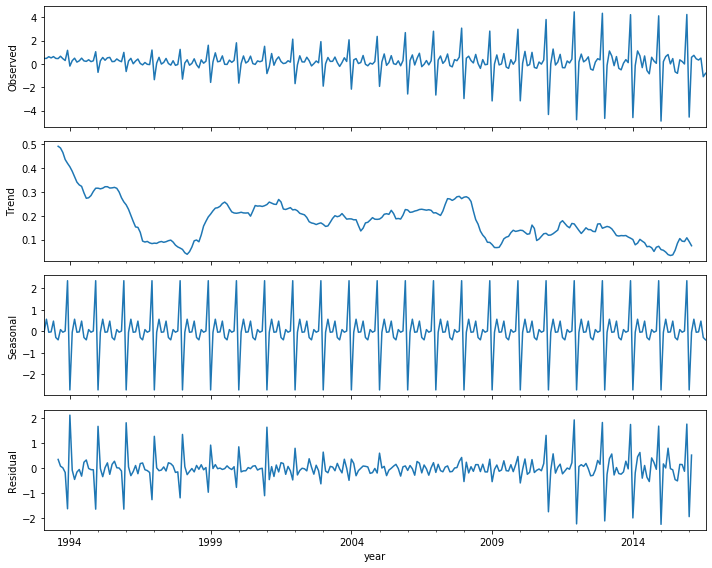

In [624]:
data['WAG_C_M_boxcox_diff'] = differentiation(data['WAG_C_M_boxcox'], period=1)

print('Dickey-Fuller test: pvalue = ', stationarity(data['WAG_C_M_boxcox_diff'].dropna())[1])

STL = STLdecomp(data['WAG_C_M_boxcox_diff'].dropna())
STL.plot()
plt.xlabel('year')
plt.show()

*double diff*

Dickey-Fuller test: pvalue =  1.0109848634915955e-22


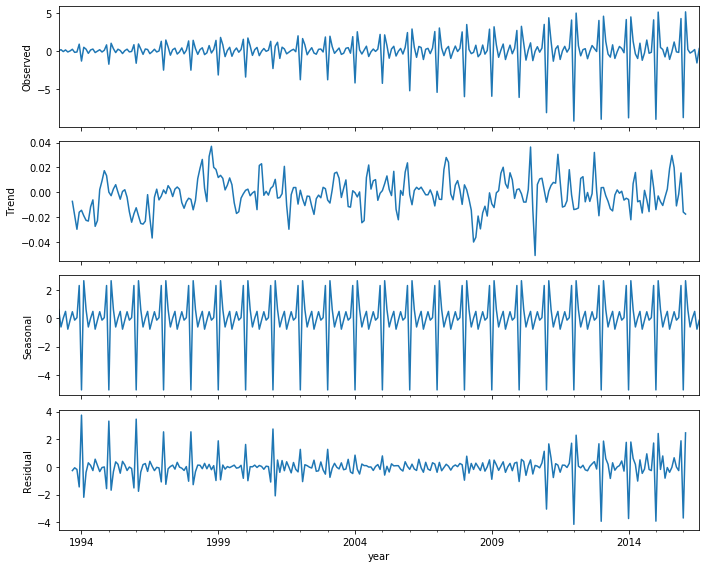

In [625]:
data['WAG_C_M_boxcox_diff2'] = differentiation(data['WAG_C_M_boxcox_diff'], period=1)

print('Dickey-Fuller test: pvalue = ', stationarity(data['WAG_C_M_boxcox_diff2'].dropna())[1])

STL = STLdecomp(data['WAG_C_M_boxcox_diff2'].dropna())
STL.plot()
plt.xlabel('year')
plt.show()

As a result, we don't have any trend (all values are about '0' with some dispersion). <br>
Dickey-Fuller test confirms the stationarity hypothesis.

---

## 3. Modeling

In [629]:
# autocorrelation & partial autocorrelation
def autocorr(series, partial=False, lags=50, figsize=[15, 8]):
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(2, 1, 1)
    sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=lags, ax=ax)
    
    if partial:
        ax = plt.subplot(2, 1, 2)
        sm.graphics.tsa.plot_pacf(series.values.squeeze(), lags=lags, ax=ax)


def best_params_model(series, params, trend, d=1, D=1, print_wrong_params=True):
    '''
    Input
    ----------
    params : list
        [ps, qs, Ps, Qs]
        
    Output
    ----------
    df_res : pd.DataFrame 
    
    best_model : statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrappero object
    
    '''
    
    results = []
    best_aic = np.inf
    warnings.filterwarnings('ignore')
    
    for p, q, P, Q in params:
        # try except because model can't fit by some params
        try: 
            model=sm.tsa.statespace.SARIMAX(series, order=(p, d, q), 
                                            seasonal_order=(P, D, Q, trend)).fit(disp=-1)
        except ValueError:
            if print_wrong_params:
                print('wrong parameters: ', p, q, P, Q)
            continue
            
        aic = model.aic
        # best model 
        if aic < best_aic:
            best_model = model
        results.append([p, q, P, Q, model.aic])
    
    warnings.filterwarnings('default')
    
    df_res = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic', ascending=True)
    return df_res, best_model


def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

*Check autocorr to select initial parameters*

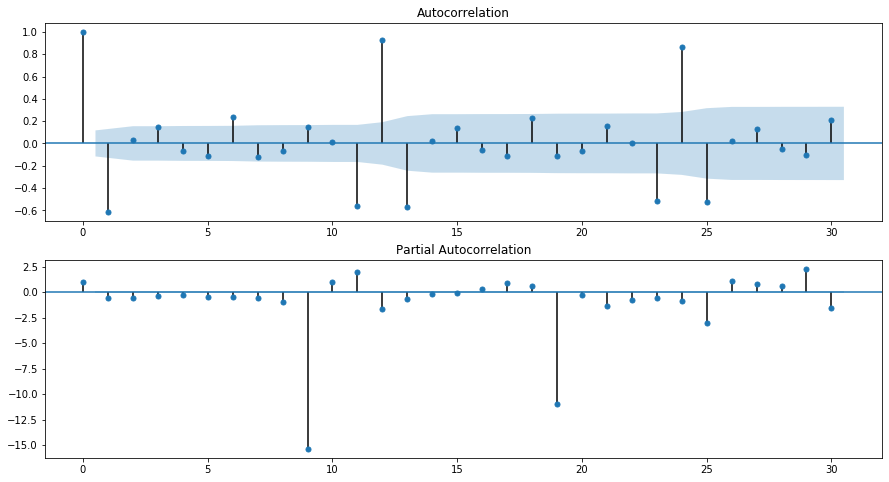

In [363]:
autocorr(data['WAG_C_M_boxcox_diff2'].dropna(), partial=True)

*Tune params and check model*

In [630]:
%%time

Q, q, P, p = 1, 1, 1, 9
Qs, qs, Ps, ps = range(Q + 1), range(q + 1), range(P + 1), range(p + 1)
params = pd.DataFrame(product(ps, qs, Ps, Qs), columns=['ps', 'qs', 'Ps', 'Qs'])

models_res, best_model = best_params_model(data['WAG_C_M_boxcox'].dropna(), params.values, 12)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  284
Model:             SARIMAX(9, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  13.874
Date:                            Tue, 05 May 2020   AIC                             -1.749
Time:                                    01:17:44   BIC                             45.079
Sample:                                01-01-1993   HQIC                            17.053
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5153      1.023     -0.504      0.614      -2.520       1.489
ar.L2         -0.0316      0.209   

Student test: pvalue =  0.5184951308520063
Dickey-Fuller test: pvalue =  0.6968987634832662


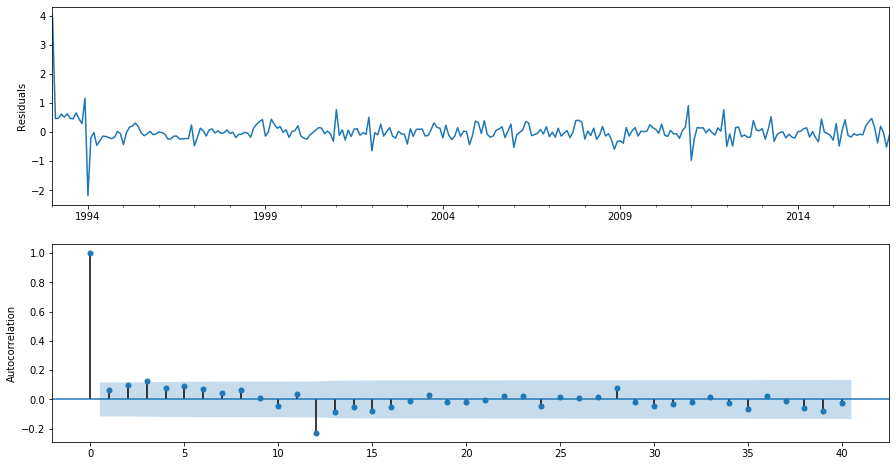

In [533]:
plt.figure(figsize=[15, 8])
plt.subplot(2, 1, 1)
best_model.resid.dropna().plot()
plt.ylabel('Residuals')
plt.xlabel(None)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags=40, ax=ax)
plt.title(None)
plt.ylabel('Autocorrelation')

print('Student test: pvalue = ', stats.ttest_1samp(best_model.resid.dropna(), 0)[1])
print('Dickey-Fuller test: pvalue = ', stationarity(data['WAG_C_M_boxcox'])[1])

*Model adequacy*

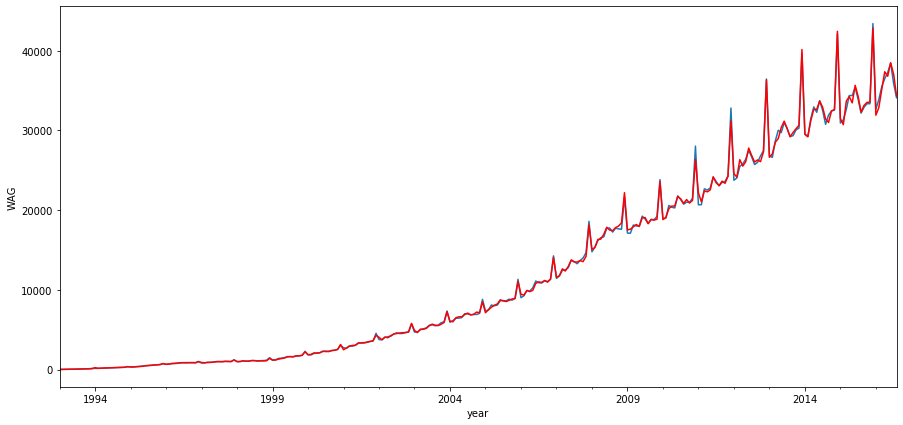

In [627]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=[15, 7])
data['WAG_C_M'].plot()
data['model'].dropna().plot(color='r')
plt.ylabel('WAG')
plt.xlabel('year')
plt.show()

---

## 4. Predict 

In [651]:
dates_to_pred = pd.date_range('2016-09-01', '2019-01-01', freq='MS')
preds = invboxcox(best_model.predict(start=data.shape[0], end=data.shape[0] + len(dates_to_pred)), lmbda)

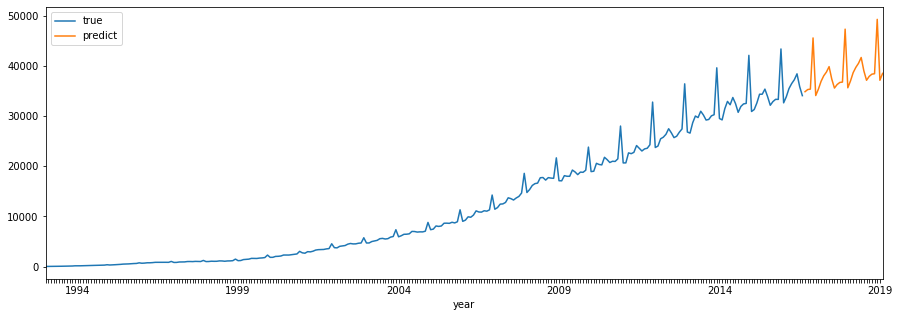

In [652]:
plt.figure(figsize=[15, 5])
data['WAG_C_M'].plot(label='true')
preds.plot(label='predict')
plt.xticks(list(data.index) + list(dates_to_pred.values))
plt.xlabel('year')
plt.legend()
plt.show()